# Method 2 - Best Ideas Medium Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['size_pct'] > (1 / 3)) & (best_ideas['size_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

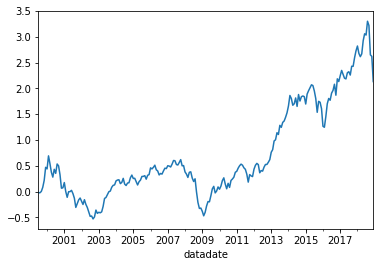

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.471020
2000-12-31   -0.269827
2001-12-31   -0.183690
2002-12-31   -0.339259
2003-12-31    0.952210
2004-12-31    0.168076
2005-12-31    0.006789
2006-12-31    0.087678
2007-12-31    0.040213
2008-12-31   -0.546617
2009-12-31    0.599532
2010-12-31    0.259783
2011-12-31   -0.060256
2012-12-31    0.254220
2013-12-31    0.560471
2014-12-31    0.123347
2015-12-31   -0.081750
2016-12-31    0.201020
2017-12-31    0.190108
2018-12-31   -0.159786
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     457.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.73e-108
Time:                        01:26:33   Log-Likelihood:                 529.06
No. Observations:                 234   AIC:                            -1048.
Df Residuals:                     229   BIC:                            -1031.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      2.410      0.017       0.001       0.008
mktrf          1.1413      0.048     23.997      0.000       1.048       1.235
me             0.4477      0.055      8.093      0.000       0.339       0.557
ia            -0.1090      0.084     -1.296      0.196      -0.275       0.057
roe           -0.6913      0.072     -9.606      0.000      -0.833      -0.550
==============================================================================
Omnibus:                       31.112   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.944
Skew:                           0.613   Prob(JB):                     1.45e-16
Kurtosis:                       5.445   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     547.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.06e-116
Time:                        01:26:33   Log-Likelihood:                 529.06
No. Observations:                 234   AIC:                            -1048.
Df Residuals:                     229   BIC:                            -1031.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      1.956      0.051   -9.17e-06       0.008
mktrf          1.1413      0.040     28.410      0.000       1.063       1.220
me             0.4477      0.050      8.900      0.000       0.349       0.546
ia            -0.1090      0.125     -0.869      0.385      -0.355       0.137
roe           -0.6913      0.129     -5.346      0.000      -0.945      -0.438
==============================================================================
Omnibus:                       31.112   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.944
Skew:                           0.613   Prob(JB):                     1.45e-16
Kurtosis:                       5.445   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     765.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.35e-131
Time:                        01:26:34   Log-Likelihood:                 529.06
No. Observations:                 234   AIC:                            -1048.
Df Residuals:                     229   BIC:                            -1031.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      1.975      0.048    3.09e-05       0.008
mktrf          1.1413      0.038     30.338      0.000       1.068       1.215
me             0.4477      0.054      8.338      0.000       0.342       0.553
ia            -0.1090      0.108     -1.009      0.313      -0.321       0.103
roe           -0.6913      0.134     -5.166      0.000      -0.954      -0.429
==============================================================================
Omnibus:                       31.112   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.944
Skew:                           0.613   Prob(JB):                     1.45e-16
Kurtosis:                       5.445   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     358.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.44e-106
Time:                        01:26:34   Log-Likelihood:                 527.27
No. Observations:                 234   AIC:                            -1043.
Df Residuals:                     228   BIC:                            -1022.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.081      0.039       0.000       0.007
mktrf          1.2120      0.048     25.184      0.000       1.117       1.307
smb            0.4542      0.063      7.153      0.000       0.329       0.579
hml           -0.0320      0.075     -0.428      0.669      -0.180       0.115
rmw           -0.6766      0.085     -7.993      0.000      -0.843      -0.510
cma            0.1005      0.108      0.934      0.351      -0.112       0.313
==============================================================================
Omnibus:                       20.131   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.437
Skew:                           0.512   Prob(JB):                     9.04e-08
Kurtosis:                       4.510   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     249.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.00e-90
Time:                        01:26:34   Log-Likelihood:                 527.27
No. Observations:                 234   AIC:                            -1043.
Df Residuals:                     228   BIC:                            -1022.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      1.899      0.058      -0.000       0.008
mktrf          1.2120      0.049     24.586      0.000       1.115       1.309
smb            0.4542      0.067      6.809      0.000       0.323       0.585
hml           -0.0320      0.127     -0.253      0.800      -0.280       0.216
rmw           -0.6766      0.142     -4.766      0.000      -0.955      -0.398
cma            0.1005      0.149      0.674      0.500      -0.192       0.393
==============================================================================
Omnibus:                       20.131   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.437
Skew:                           0.512   Prob(JB):                     9.04e-08
Kurtosis:                       4.510   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     274.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.55e-94
Time:                        01:26:34   Log-Likelihood:                 527.27
No. Observations:                 234   AIC:                            -1043.
Df Residuals:                     228   BIC:                            -1022.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      1.971      0.049    2.12e-05       0.007
mktrf          1.2120      0.051     23.728      0.000       1.112       1.312
smb            0.4542      0.063      7.165      0.000       0.330       0.578
hml           -0.0320      0.100     -0.320      0.749      -0.228       0.164
rmw           -0.6766      0.144     -4.683      0.000      -0.960      -0.393
cma            0.1005      0.126      0.801      0.423      -0.146       0.346
==============================================================================
Omnibus:                       20.131   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.437
Skew:                           0.512   Prob(JB):                     9.04e-08
Kurtosis:                       4.510   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     366.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.88e-98
Time:                        01:26:34   Log-Likelihood:                 506.21
No. Observations:                 234   AIC:                            -1002.
Df Residuals:                     229   BIC:                            -985.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.740      0.460      -0.002       0.005
mktrf          1.2972      0.048     26.867      0.000       1.202       1.392
smb            0.7244      0.060     12.019      0.000       0.606       0.843
hml           -0.1272      0.060     -2.124      0.035      -0.245      -0.009
umd           -0.1674      0.039     -4.263      0.000      -0.245      -0.090
==============================================================================
Omnibus:                       48.338   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.221
Skew:                           0.912   Prob(JB):                     3.90e-28
Kurtosis:                       6.101   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     366.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.90e-98
Time:                        01:26:34   Log-Likelihood:                 506.21
No. Observations:                 234   AIC:                            -1002.
Df Residuals:                     229   BIC:                            -985.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.675      0.500      -0.003       0.005
mktrf          1.2972      0.046     28.043      0.000       1.207       1.388
smb            0.7244      0.063     11.562      0.000       0.602       0.847
hml           -0.1272      0.090     -1.414      0.157      -0.303       0.049
umd           -0.1674      0.074     -2.255      0.024      -0.313      -0.022
==============================================================================
Omnibus:                       48.338   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.221
Skew:                           0.912   Prob(JB):                     3.90e-28
Kurtosis:                       6.101   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     332.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.63e-94
Time:                        01:26:34   Log-Likelihood:                 506.21
No. Observations:                 234   AIC:                            -1002.
Df Residuals:                     229   BIC:                            -985.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.711      0.477      -0.002       0.005
mktrf          1.2972      0.049     26.433      0.000       1.201       1.393
smb            0.7244      0.062     11.721      0.000       0.603       0.845
hml           -0.1272      0.080     -1.588      0.112      -0.284       0.030
umd           -0.1674      0.080     -2.099      0.036      -0.324      -0.011
==============================================================================
Omnibus:                       48.338   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.221
Skew:                           0.912   Prob(JB):                     3.90e-28
Kurtosis:                       6.101   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     238.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.23e-54
Time:                        01:26:34   Log-Likelihood:                 254.59
No. Observations:                 120   AIC:                            -499.2
Df Residuals:                     115   BIC:                            -485.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.847      0.067      -0.000       0.011
mktrf          1.1714      0.076     15.341      0.000       1.020       1.323
me             0.4124      0.075      5.468      0.000       0.263       0.562
ia            -0.1631      0.118     -1.381      0.170      -0.397       0.071
roe           -0.6376      0.105     -6.100      0.000      -0.845      -0.431
==============================================================================
Omnibus:                       17.038   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.791
Skew:                           0.612   Prob(JB):                     2.06e-07
Kurtosis:                       5.159   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     288.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.29e-59
Time:                        01:26:34   Log-Likelihood:                 254.59
No. Observations:                 120   AIC:                            -499.2
Df Residuals:                     115   BIC:                            -485.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.004      1.351      0.177      -0.002       0.013
mktrf          1.1714      0.059     19.722      0.000       1.055       1.288
me             0.4124      0.072      5.751      0.000       0.272       0.553
ia            -0.1631      0.184     -0.885      0.376      -0.524       0.198
roe           -0.6376      0.185     -3.450      0.001      -1.000      -0.275
==============================================================================
Omnibus:                       17.038   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.791
Skew:                           0.612   Prob(JB):                     2.06e-07
Kurtosis:                       5.159   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     451.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.64e-69
Time:                        01:26:34   Log-Likelihood:                 254.59
No. Observations:                 120   AIC:                            -499.2
Df Residuals:                     115   BIC:                            -485.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.004      1.359      0.174      -0.002       0.013
mktrf          1.1714      0.056     20.776      0.000       1.061       1.282
me             0.4124      0.076      5.409      0.000       0.263       0.562
ia            -0.1631      0.165     -0.988      0.323      -0.487       0.160
roe           -0.6376      0.192     -3.322      0.001      -1.014      -0.261
==============================================================================
Omnibus:                       17.038   Durbin-Watson:                   2.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.791
Skew:                           0.612   Prob(JB):                     2.06e-07
Kurtosis:                       5.159   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     204.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.32e-55
Time:                        01:26:34   Log-Likelihood:                 258.93
No. Observations:                 120   AIC:                            -505.9
Df Residuals:                     114   BIC:                            -489.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.003      2.204      0.030       0.001       0.012
mktrf          1.3098      0.078     16.795      0.000       1.155       1.464
smb            0.4253      0.088      4.815      0.000       0.250       0.600
hml           -0.1611      0.108     -1.488      0.139      -0.376       0.053
rmw           -0.5472      0.128     -4.287      0.000      -0.800      -0.294
cma            0.1652      0.140      1.181      0.240      -0.112       0.442
==============================================================================
Omnibus:                        9.379   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.516
Skew:                           0.504   Prob(JB):                      0.00521
Kurtosis:                       4.042   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     194.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.66e-54
Time:                        01:26:34   Log-Likelihood:                 258.93
No. Observations:                 120   AIC:                            -505.9
Df Residuals:                     114   BIC:                            -489.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.003      1.992      0.046    9.85e-05       0.012
mktrf          1.3098      0.071     18.494      0.000       1.171       1.449
smb            0.4253      0.085      5.002      0.000       0.259       0.592
hml           -0.1611      0.150     -1.076      0.282      -0.455       0.132
rmw           -0.5472      0.192     -2.847      0.004      -0.924      -0.170
cma            0.1652      0.172      0.962      0.336      -0.171       0.502
==============================================================================
Omnibus:                        9.379   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.516
Skew:                           0.504   Prob(JB):                      0.00521
Kurtosis:                       4.042   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     294.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.83e-63
Time:                        01:26:34   Log-Likelihood:                 258.93
No. Observations:                 120   AIC:                            -505.9
Df Residuals:                     114   BIC:                            -489.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.003      1.998      0.046       0.000       0.012
mktrf          1.3098      0.066     19.747      0.000       1.180       1.440
smb            0.4253      0.075      5.682      0.000       0.279       0.572
hml           -0.1611      0.127     -1.268      0.205      -0.410       0.088
rmw           -0.5472      0.199     -2.752      0.006      -0.937      -0.157
cma            0.1652      0.135      1.222      0.222      -0.100       0.430
==============================================================================
Omnibus:                        9.379   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.516
Skew:                           0.504   Prob(JB):                      0.00521
Kurtosis:                       4.042   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     217.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.22e-52
Time:                        01:26:34   Log-Likelihood:                 249.78
No. Observations:                 120   AIC:                            -489.6
Df Residuals:                     115   BIC:                            -475.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.003      1.339      0.183      -0.002       0.010
mktrf          1.3933      0.070     19.901      0.000       1.255       1.532
smb            0.6555      0.080      8.223      0.000       0.498       0.813
hml           -0.2162      0.080     -2.708      0.008      -0.374      -0.058
umd           -0.1212      0.049     -2.462      0.015      -0.219      -0.024
==============================================================================
Omnibus:                       26.241   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.805
Skew:                           0.910   Prob(JB):                     5.63e-12
Kurtosis:                       5.655   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     390.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.73e-66
Time:                        01:26:34   Log-Likelihood:                 249.78
No. Observations:                 120   AIC:                            -489.6
Df Residuals:                     115   BIC:                            -475.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.003      1.203      0.229      -0.002       0.010
mktrf          1.3933      0.043     32.662      0.000       1.310       1.477
smb            0.6555      0.078      8.385      0.000       0.502       0.809
hml           -0.2162      0.101     -2.144      0.032      -0.414      -0.019
umd           -0.1212      0.082     -1.477      0.140      -0.282       0.040
==============================================================================
Omnibus:                       26.241   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.805
Skew:                           0.910   Prob(JB):                     5.63e-12
Kurtosis:                       5.655   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     603.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.61e-76
Time:                        01:26:34   Log-Likelihood:                 249.78
No. Observations:                 120   AIC:                            -489.6
Df Residuals:                     115   BIC:                            -475.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.003      1.271      0.204      -0.002       0.010
mktrf          1.3933      0.034     41.347      0.000       1.327       1.459
smb            0.6555      0.080      8.188      0.000       0.499       0.812
hml           -0.2162      0.091     -2.366      0.018      -0.395      -0.037
umd           -0.1212      0.084     -1.442      0.149      -0.286       0.044
==============================================================================
Omnibus:                       26.241   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.805
Skew:                           0.910   Prob(JB):                     5.63e-12
Kurtosis:                       5.655   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     209.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.19e-50
Time:                        01:26:34   Log-Likelihood:                 284.31
No. Observations:                 114   AIC:                            -558.6
Df Residuals:                     109   BIC:                            -544.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      1.947      0.054    -7.1e-05       0.008
mktrf          1.0846      0.060     18.052      0.000       0.966       1.204
me             0.5614      0.093      6.052      0.000       0.378       0.745
ia            -0.0284      0.129     -0.220      0.826      -0.283       0.227
roe           -0.7934      0.113     -7.017      0.000      -1.017      -0.569
==============================================================================
Omnibus:                       16.850   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.440
Skew:                           0.705   Prob(JB):                     2.99e-06
Kurtosis:                       4.835   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     456.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.46e-67
Time:                        01:26:34   Log-Likelihood:                 284.31
No. Observations:                 114   AIC:                            -558.6
Df Residuals:                     109   BIC:                            -544.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.528      0.011       0.001       0.007
mktrf          1.0846      0.049     22.147      0.000       0.989       1.181
me             0.5614      0.058      9.644      0.000       0.447       0.675
ia            -0.0284      0.140     -0.202      0.840      -0.304       0.247
roe           -0.7934      0.121     -6.536      0.000      -1.031      -0.555
==============================================================================
Omnibus:                       16.850   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.440
Skew:                           0.705   Prob(JB):                     2.99e-06
Kurtosis:                       4.835   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     726.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.42e-77
Time:                        01:26:34   Log-Likelihood:                 284.31
No. Observations:                 114   AIC:                            -558.6
Df Residuals:                     109   BIC:                            -544.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      2.647      0.008       0.001       0.007
mktrf          1.0846      0.038     28.494      0.000       1.010       1.159
me             0.5614      0.059      9.529      0.000       0.446       0.677
ia            -0.0284      0.135     -0.209      0.834      -0.294       0.237
roe           -0.7934      0.102     -7.802      0.000      -0.993      -0.594
==============================================================================
Omnibus:                       16.850   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.440
Skew:                           0.705   Prob(JB):                     2.99e-06
Kurtosis:                       4.835   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     145.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.51e-46
Time:                        01:26:34   Log-Likelihood:                 277.70
No. Observations:                 114   AIC:                            -543.4
Df Residuals:                     108   BIC:                            -527.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.937      0.351      -0.002       0.006
mktrf          1.1252      0.061     18.445      0.000       1.004       1.246
smb            0.5496      0.099      5.550      0.000       0.353       0.746
hml            0.0647      0.126      0.512      0.610      -0.186       0.315
rmw           -0.7982      0.155     -5.161      0.000      -1.105      -0.492
cma            0.0810      0.196      0.413      0.681      -0.308       0.470
==============================================================================
Omnibus:                        8.325   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.328
Skew:                           0.533   Prob(JB):                       0.0155
Kurtosis:                       3.786   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     109.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.25e-40
Time:                        01:26:34   Log-Likelihood:                 277.70
No. Observations:                 114   AIC:                            -543.4
Df Residuals:                     108   BIC:                            -527.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      1.021      0.307      -0.002       0.006
mktrf          1.1252      0.066     17.083      0.000       0.996       1.254
smb            0.5496      0.080      6.882      0.000       0.393       0.706
hml            0.0647      0.154      0.420      0.674      -0.237       0.366
rmw           -0.7982      0.249     -3.200      0.001      -1.287      -0.309
cma            0.0810      0.189      0.429      0.668      -0.289       0.451
==============================================================================
Omnibus:                        8.325   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.328
Skew:                           0.533   Prob(JB):                       0.0155
Kurtosis:                       3.786   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     139.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.10e-45
Time:                        01:26:34   Log-Likelihood:                 277.70
No. Observations:                 114   AIC:                            -543.4
Df Residuals:                     108   BIC:                            -527.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      1.101      0.271      -0.002       0.006
mktrf          1.1252      0.066     17.008      0.000       0.996       1.255
smb            0.5496      0.079      6.931      0.000       0.394       0.705
hml            0.0647      0.161      0.403      0.687      -0.250       0.379
rmw           -0.7982      0.247     -3.228      0.001      -1.283      -0.314
cma            0.0810      0.205      0.396      0.692      -0.320       0.482
==============================================================================
Omnibus:                        8.325   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.328
Skew:                           0.533   Prob(JB):                       0.0155
Kurtosis:                       3.786   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     150.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.78e-43
Time:                        01:26:34   Log-Likelihood:                 268.01
No. Observations:                 114   AIC:                            -526.0
Df Residuals:                     109   BIC:                            -512.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.542      0.589      -0.003       0.006
mktrf          1.1572      0.066     17.617      0.000       1.027       1.287
smb            0.7337      0.102      7.163      0.000       0.531       0.937
hml            0.1454      0.105      1.378      0.171      -0.064       0.354
umd           -0.2031      0.080     -2.552      0.012      -0.361      -0.045
==============================================================================
Omnibus:                       20.237   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.707
Skew:                           0.767   Prob(JB):                     1.76e-08
Kurtosis:                       5.272   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     184.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.32e-47
Time:                        01:26:34   Log-Likelihood:                 268.01
No. Observations:                 114   AIC:                            -526.0
Df Residuals:                     109   BIC:                            -512.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.679      0.497      -0.002       0.005
mktrf          1.1572      0.061     18.871      0.000       1.037       1.277
smb            0.7337      0.084      8.740      0.000       0.569       0.898
hml            0.1454      0.171      0.849      0.396      -0.190       0.481
umd           -0.2031      0.059     -3.437      0.001      -0.319      -0.087
==============================================================================
Omnibus:                       20.237   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.707
Skew:                           0.767   Prob(JB):                     1.76e-08
Kurtosis:                       5.272   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     179.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.20e-47
Time:                        01:26:34   Log-Likelihood:                 268.01
No. Observations:                 114   AIC:                            -526.0
Df Residuals:                     109   BIC:                            -512.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.711      0.477      -0.002       0.005
mktrf          1.1572      0.057     20.393      0.000       1.046       1.268
smb            0.7337      0.068     10.807      0.000       0.601       0.867
hml            0.1454      0.177      0.821      0.412      -0.202       0.492
umd           -0.2031      0.048     -4.201      0.000      -0.298      -0.108
==============================================================================
Omnibus:                       20.237   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.707
Skew:                           0.767   Prob(JB):                     1.76e-08
Kurtosis:                       5.272   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""